# Assignment 5


*Please fill out the relevant cells below according to the instructions. When done, save the notebook and export it to PDF, upload both the `ipynb` and the PDF file to Canvas.*

## Group Members

*Group submission is highly encouraged. If you submit as part of group, list all group members here. Groups can comprise up to 4 students.*

* Declan Campbell
* Vanessa Roser
* Yunchang Zhang

---

## Problem 1: Automatic Hubble (3pts)

Go back to Assignment 3. Get the Hubble data and take the GP error model from Problem 1.3 to solve the linear regression with correlated errors, but this time use `emcee` to get the posteriors.

Adopt non-informative priors, i.e. $p(b) \propto (1+b^2)^{-3/2}$ and $p(\sigma_y)\propto 1/\sigma_y$, and whatever you feel is appropriate for the priors of the parameter $\alpha$ and $\tau$ of the Matern kernel.

Plot the parameter contours with `corner` and make another plot that compares the data with samples of the posterior.

In [2]:
#%pip install jax
#%pip install -U emcee
#%pip install corner

import numpy as np
import matplotlib.pyplot as plt
import corner
from scipy import stats
import jax.numpy as jnp

#from jax import grad
from sklearn.metrics import pairwise_distances
import emcee

In [3]:
hubble = np.loadtxt('data.txt')

x = hubble[:,0].reshape(1,-1)[0]
y = hubble[:,1].reshape(1,-1)[0]

# start at the MLE
X = np.vander(x, N=2, increasing=True)
x_mle = np.linalg.inv(X.T @ X) @ X.T @ y # give slope and intercept a/b

b = .0015
sigma = 0.1
alpha = 1
tau = 100

params = np.asarray([sigma, alpha, tau, b])

def log_prior(params):
    sigma, alpha, tau, b = params
    if tau < 0 or alpha < 0 or sigma <= 0:
         return -np.inf
    lp = (-3/2)*np.log((1+b**2)) + np.log(1/sigma) + stats.gamma.logpdf(alpha, a=2, scale=1) + stats.gamma.logpdf(tau, scale=100, a=10) #np.log(1.0/(np.sqrt(2*np.pi)*sigma1))-0.5*(b-mu1)**2/sigma1**2
    return lp 

def get_kernel(X,alpha,tau):
    d = np.asarray(pairwise_distances(X))
    kern = alpha**2*(1 + (np.sqrt(3)*d)/tau) * np.exp((-np.sqrt(3)*d)/tau)  
    return kern

def get_K(X,sigma,alpha,tau):
    K = np.diag(np.repeat(sigma**2, len(X)))
    return K + get_kernel(X,alpha,tau)

def get_prob(params, X, Y):
    N = len(X)
    sigma, alpha, tau, b = params
    e = Y - b*X
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    K_new = get_K(X,sigma, alpha, tau)
    lkhd = (-0.5*(e.T) @ np.linalg.inv(K_new) @ e)[0][0] - 0.5*np.log(np.linalg.det(K_new))- (N/2)*(np.log(2*np.pi))
    return lkhd + lp 

# create a small ball around the MLE the initialize each walker 
nwalkers, ndim = 30, 4
pos = params + 1e-4 * np.random.randn(nwalkers, ndim)

# run emcee
x = hubble[:,0].reshape(-1,1)
y = hubble[:,1].reshape(-1,1)
sampler = emcee.EnsembleSampler(nwalkers, ndim, get_prob, args=(x, y))
sampler.run_mcmc(pos,5000, progress=True); #5000

100%|██████████| 5000/5000 [02:27<00:00, 33.79it/s]


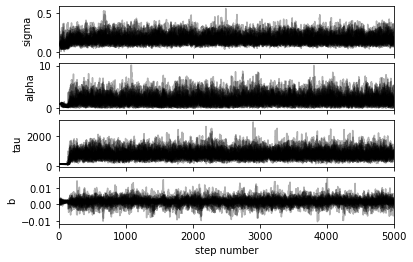

In [70]:
fig, axes = plt.subplots(ndim, sharex=True)
samples = sampler.get_chain()
labels = ['sigma', 'alpha', 'tau', 'b']
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3, rasterized=True)
    ax.set_xlim(0, 5000)
    ax.set_ylabel(labels[i])

axes[-1].set_xlabel("step number");
axes[0].set_title("MCMC chains for the parameters");

autocorr t: [77.67226706 76.95875299 80.56774718 52.79756079]


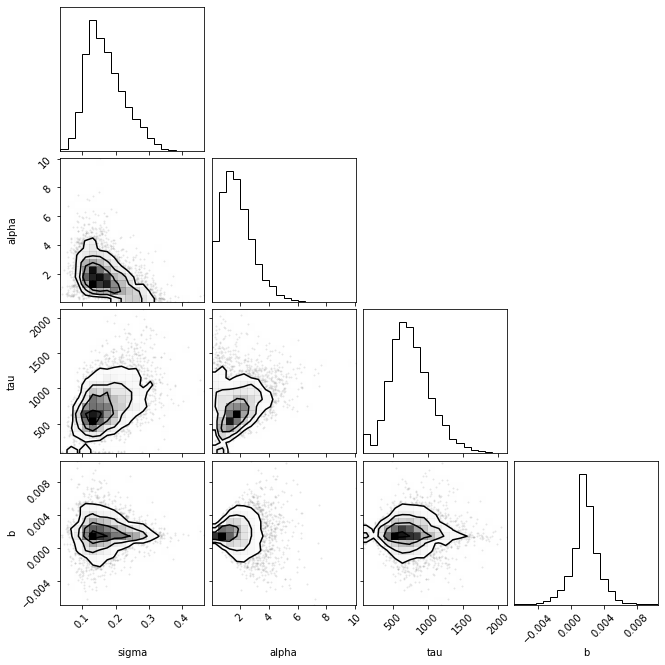

In [71]:
tau = sampler.get_autocorr_time()
print("autocorr t:",tau)
flat_samples = sampler.get_chain(discard=10, thin=int(np.mean(tau[0])/2), flat=True)

fig = corner.corner(flat_samples, labels=labels, truths=params)
title = fig.suptitle("Posterior distributions for the parameters with initial guess", y=1.05)

[1.70257232e-01 1.84896742e+00 7.60587329e+02 1.73314063e-03]


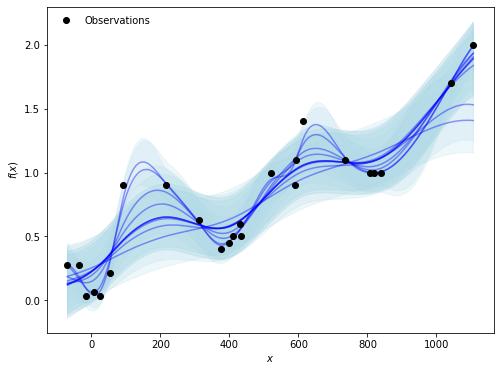

In [85]:
inds = np.random.randint(len(flat_samples), size=10)
print(np.mean(flat_samples,axis=0))
X = hubble[:,0].reshape(-1,1)
y = hubble[:,1].reshape(-1,1)
x_pred = np.linspace(np.min(X), np.max(X), 1000).reshape(-1,1)
X_full = np.concatenate((X,x_pred))

plt.figure(figsize=(8,6), facecolor='white')

plt.plot(X, y, 'ko', zorder=10, label='Observations')
#labels = ['sigma', 'alpha', 'tau', 'b']
for ind in inds:
    sample = flat_samples[ind]
    K_full = get_K(X_full,sample[0],sample[1],sample[2])
    # Plot the function, the prediction and the 95% confidence interval based on the MSE
    e_out = y - sample[3]*X

    #get the mean and cov of the GP for e
    K_X = K_full[:len(X),:len(X)]
    K_Xstar = K_full[:len(X),len(X):]
    K_star = K_full[len(X):,len(X):]
    y_pred = K_Xstar.T@np.linalg.inv(K_X)@y
    y_std = np.sqrt(np.diagonal(K_star-K_Xstar.T@np.linalg.inv(K_X)@K_Xstar))
    y_std=y_std.reshape(-1,1)
    plt.plot(x_pred,y_pred,color='b',alpha=0.4)
    plt.fill(np.concatenate([x_pred, x_pred[::-1]]), np.concatenate([y_pred - 1 * y_std, (y_pred + 1 * y_std)[::-1]]), alpha=.2, ec='None', color='lightblue')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.legend(loc='upper left', frameon=False)

## Problem 2: HMC for Hierarchical Regression (7pts)

Implement the hierarchical linear regression model for math scores vs socio-econonic status (SES) from 100 schools we discussed in the lecture. But instead of the complicated Gibbs sampling sequence with its full conditionals, compute posteriors with HMC/NUTS.

## Problem 2.1 (3pts):

Get the data from the Hoff 2009 book [here](https://github.com/probml/pmtk3/blob/master/data/mathDataHoff.csv).
Treat each school independently and perform linear regression (with an unknown error) of math score as function of SES. Specifically, implement this model in `numpyro`:

\begin{align}
\mu &\sim \mathcal{N}(\mu_0, V_0)\\
\Sigma &\sim \mathrm{IW} (\eta_0, S_0^{-1})\\
w_j&\sim\mathcal{N}(\mu,\Sigma)\\
\sigma^2 &\sim \mathrm{IG} (\tfrac{1}{2}\nu_0, \tfrac{1}{2}\nu_0 \sigma_0^2)\\
e_{ij}&\sim\mathcal{N}(0, \sigma^2)
\end{align}

Take the mean of the posterior samples for the per-school linear regression weights and make a plot of these mean posterior predictions (see panel a) of Murphy Fig. 24.4). Store the posterior means of $w_j$ and $\sigma_j$ for every school for Problem 2.3.

**Hints**: 

* Pick reasonable values for the hyper-parameters $\mu_0, V_0,\dots$. A good method is to plot the resulting parameter distributions and compare them to the data. They should be wide enough to not overly influence the inference.
* The inverse Wishart distribution is not available in NumPyro yet. For univariate cases, it is identical to the inverse Gamma distribution. For the $2\times 2$ covariance $\Sigma$, assume independence of the slope and the intercept variances. Thus, sample two independent RVs from the inverse Gamma and treat them like a diagonal matrix covariance matrix. 
*
import jax.numpy as np
import numpy as onp
```

In [161]:
#%pip install numpyro
import numpyro as npr
import jax.numpy as np
from jax import random
import numpy as onp
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
import matplotlib.pyplot as plt
import corner
from jax import jit

In [4]:
## Read data
import pandas as pd
df = pd.read_csv('Hoffdata.csv')
df.head()

## Preprocess data
# Get all the school ids
school_ids = df['sch_id'].unique()

In [5]:
import jax.numpy as np
from jax import random
import numpy as onp

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

def model(x, y=None):
    mu_0_1 = 50
    mu_0_2 = 3
    V_0 = 5
    v_0 = 1
    sigma_0 = 1

    Sigma_1 = numpyro.sample('Sigma_1', dist.InverseGamma(1,2))
    Sigma_2 = numpyro.sample('Sigma_2', dist.InverseGamma(1,2))
    sigma = numpyro.sample('sigma', 
                                  dist.InverseGamma(v_0/2, v_0*sigma_0**2/2))
    mu1 = numpyro.sample('mu1', dist.Normal(mu_0_1, V_0))
    mu2 = numpyro.sample('mu2', dist.Normal(mu_0_2, V_0))
    w1 = numpyro.sample('w1', dist.Normal(mu1, Sigma_1))
    w2 = numpyro.sample('w2', dist.Normal(mu2, Sigma_2))
   
    e = numpyro.sample('e',dist.Normal(0, sigma))

    y_ = w1 + w2*x
    # notice that we clamp the outcome of this sampling to the observation y 
    numpyro.sample('obs', dist.Normal(y_, e), obs=y)

# need to split the key for jax's random implementation
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

# Create space for storing the posterior means of w_j and sigma_square
w1_posterior_mean = onp.zeros(len(school_ids))
w2_posterior_mean = onp.zeros(len(school_ids))
sigma_posterior_mean = onp.zeros(len(school_ids))

# Loop throug each school and fit a model
for i,school_id in enumerate(school_ids[:10]):
    # Get the data for this school
    df_school = df[df['sch_id'] == school_id]
    print("Fitting model for school: ", school_id)
    # Get the x and y values
    x = df_school['stu_ses'].values
    y = df_school['stu_mathscore'].values
    # Fit the model
    kernel = NUTS(model, target_accept_prob=0.9)
    mcmc = MCMC(kernel, num_warmup=1000, num_samples=3000)
    mcmc.run(random.PRNGKey(0), x=x, y=y)
    #mcmc.print_summary()

    # Get and store the mean of the posterior samples
    w1_posterior_mean[i] = onp.mean(mcmc.get_samples()['w1'])
    w2_posterior_mean[i] = onp.mean(mcmc.get_samples()['w2'])
    sigma_posterior_mean[i] = onp.mean(mcmc.get_samples()['sigma'])

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Fitting model for school:  1011


sample: 100%|██████████| 4000/4000 [00:05<00:00, 725.22it/s, 31 steps of size 1.17e-01. acc. prob=0.98] 


Fitting model for school:  1031


sample: 100%|██████████| 4000/4000 [00:05<00:00, 749.57it/s, 15 steps of size 2.18e-01. acc. prob=0.91] 


Fitting model for school:  1033


sample: 100%|██████████| 4000/4000 [00:05<00:00, 724.68it/s, 31 steps of size 1.35e-01. acc. prob=0.97] 


Fitting model for school:  1301


sample: 100%|██████████| 4000/4000 [00:05<00:00, 741.29it/s, 15 steps of size 1.88e-01. acc. prob=0.89] 


Fitting model for school:  1302


sample: 100%|██████████| 4000/4000 [00:05<00:00, 769.12it/s, 15 steps of size 1.39e-01. acc. prob=0.96] 


Fitting model for school:  1311


sample: 100%|██████████| 4000/4000 [00:05<00:00, 690.10it/s, 15 steps of size 1.40e-01. acc. prob=0.96] 


Fitting model for school:  1312


sample: 100%|██████████| 4000/4000 [00:05<00:00, 748.24it/s, 31 steps of size 1.29e-01. acc. prob=0.97] 


Fitting model for school:  1342


sample: 100%|██████████| 4000/4000 [00:05<00:00, 709.43it/s, 31 steps of size 1.14e-01. acc. prob=0.98] 


Fitting model for school:  1362


sample: 100%|██████████| 4000/4000 [00:05<00:00, 711.92it/s, 31 steps of size 1.09e-01. acc. prob=0.98] 


Fitting model for school:  1371


sample: 100%|██████████| 4000/4000 [00:05<00:00, 731.34it/s, 31 steps of size 9.36e-02. acc. prob=0.98] 


In [ ]:
#Save off variables
with open('2.1.npy', 'wb') as f:
    np.save(f, w1_posterior_mean)
    np.save(f, w2_posterior_mean)
    np.save(f, sigma_posterior_mean)

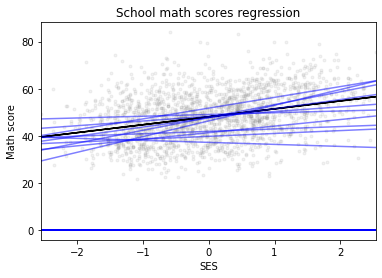

In [24]:
import matplotlib.pyplot as plt

x = df['stu_ses'].values
y = df['stu_mathscore'].values
plt.scatter(x, y,label="data", alpha=0.1,color='grey',marker='.')
plt.xlim(min(x),max(x))

x = np.vander(x, N=2, increasing=True)
x_mle = np.linalg.inv(x.T @ x) @ x.T @ y # give slope and intercept a/b
plt.plot(x, x_mle[0] + x * x_mle[1], "k", label="MLE est")

x0 = np.linspace(-3, 3, 10)
# Loop through each school and plot
for i, school_id in enumerate(school_ids):
    # Get the data for this school
    df_school = df[df['sch_id'] == school_id]
    # Get the x and y values
    x = df_school['stu_ses'].values
    y = df_school['stu_mathscore'].values

    # Get the posterior mean of w_j and sigma_square
    w1 = w1_posterior_mean[i]
    w2 = w2_posterior_mean[i]
    sigma_square = sigma_posterior_mean[i]
    # plt.errorbar(x, y, yerr=sigma_square, fmt=".k", capsize=0)
    plt.plot(x0, w1 + w2*x0, alpha=0.5, color='b')

plt.xlabel("SES")
plt.ylabel("Math score")
plt.title("School math scores regression")
plt.show()

### Problem 2.2 (3pts):

Now implement the full hierarchical scheme for the school regression coefficient $w_j$ we introduced in the lecture. Use the same hyperprior parameterization you used in 2.1. In other words, the only thing that changes is the linear model now predicts the values for the entire data set. 

Make a corner plot of the posterior for the set of hyperparameters $(\mu, \Sigma, \sigma)$. In another plot, show the linear regression from the mean posterior prediction for every school. Store the posterior means of $w_j$ for every school and of the global $\sigma$ for Problem 2.3.

**Hint:** `numpyro.plate` could be useful. 

In [25]:
from sklearn.preprocessing import LabelEncoder

def model(x,y,school_code=None):
    mu_0_1 = 50
    mu_0_2 = 3
    V_0 = 5
    v_0 = 1
    sigma_0 = 1

    Sigma_1 = numpyro.sample('Sigma_1', dist.InverseGamma(1,2))
    Sigma_2 = numpyro.sample('Sigma_2', dist.InverseGamma(1,2))
    sigma = numpyro.sample('sigma', 
                                  dist.InverseGamma(v_0/2, v_0*sigma_0**2/2))
    mu1 = numpyro.sample('mu1', dist.Normal(mu_0_1, V_0))
    mu2 = numpyro.sample('mu2', dist.Normal(mu_0_2, V_0))

    # Get school ids
    n_schools = len(onp.unique(school_code))
    
    with numpyro.plate("plate_i", n_schools):
        w1 = numpyro.sample('w1', dist.Normal(mu1, Sigma_1))
        w2 = numpyro.sample('w2', dist.Normal(mu2, Sigma_2))
   
    e = numpyro.sample('e',dist.Normal(0, sigma))
    
    y_ = w1[school_code] + w2[school_code] * x

    n_student =  len(school_code)
    with numpyro.plate("data", n_student):
        numpyro.sample("obs", dist.Normal(y_, e), obs=y)

# Get the school code
school_encoder = LabelEncoder()
df["sch_code"] = school_encoder.fit_transform(df["sch_id"].values)
ses_obs = df['stu_ses'].values
mathscore_obs = df["stu_mathscore"].values
school_code = df["sch_code"].values

# need to split the key for jax's random implementation
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

# Get the x and y values for all schools
x = df['stu_ses'].values
y = df['stu_mathscore'].values

# Fit the model
kernel = NUTS(model, target_accept_prob=0.9)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=3000)
mcmc.run(random.PRNGKey(0), x=ses_obs, y=mathscore_obs, school_code=school_code)
mcmc.print_summary()

sample: 100%|██████████| 4000/4000 [00:13<00:00, 295.50it/s, 31 steps of size 1.85e-01. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Sigma_1      4.01      0.39      3.99      3.38      4.66   2191.48      1.00
   Sigma_2      1.37      0.36      1.37      0.74      1.95    140.62      1.01
         e      8.84      0.15      8.84      8.60      9.09   3036.69      1.00
       mu1     48.00      0.44     48.00     47.27     48.71   3690.81      1.00
       mu2      2.74      0.27      2.74      2.29      3.17   1456.00      1.00
     sigma     19.68     71.13      9.62      2.62     33.42   1708.10      1.00
     w1[0]     51.18      1.50     51.13     48.73     53.60   4515.44      1.00
     w1[1]     46.49      1.69     46.51     43.76     49.31   4599.17      1.00
     w1[2]     49.14      1.67     49.15     46.41     51.88   5762.84      1.00
     w1[3]     47.35      1.78     47.37     44.33     50.16   4728.04      1.00
     w1[4]     39.14      1.80     39.13     36.21     42.03   4560.18      1.00
     w1[5]     41.42      2

In [26]:
# Store the w1 and w2 posterior means, and sigma posterior means
w1_posterior_mean_all = onp.zeros(len(school_ids))
w2_posterior_mean_all = onp.zeros(len(school_ids))

# Loop through each school and get the posterior mean of w1, w2, and sigma
for i, school_id in enumerate(school_ids):
    # Get the posterior mean of w_j
    w1_posterior_mean_all[i] = onp.mean(mcmc.get_samples()['w1'][:,i])
    w2_posterior_mean_all[i] = onp.mean(mcmc.get_samples()['w2'][:,i])
n_schools = len(school_ids)
sigma_posterior_all = onp.array(mcmc.get_samples()['sigma'])[:n_schools]

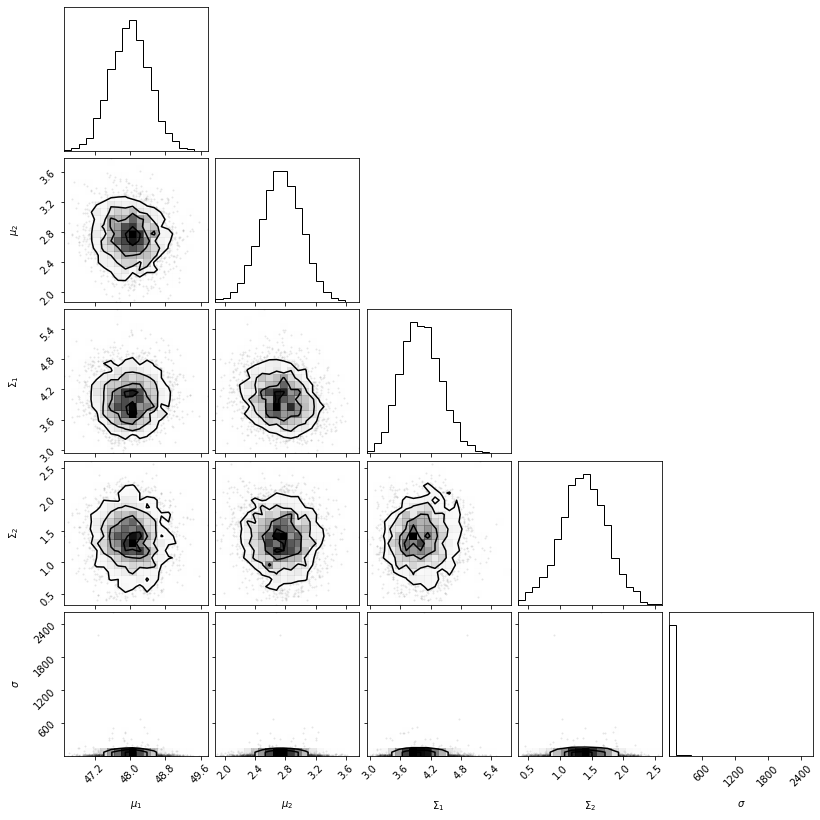

In [27]:
import corner
# Plot the posterior of the hyperparameters using corner
samples = mcmc.get_samples()
mu1 = onp.array(samples['mu1'])
mu2 = onp.array(samples['mu2'])
Sigma_1 = onp.array(samples['Sigma_1'])
Sigma_2 = onp.array(samples['Sigma_2'])
sigma = onp.array(samples['sigma'])

# Create labels for the hyperparameters
labels = [r"$\mu_1$", r"$\mu_2$", r"$\Sigma_1$", r"$\Sigma_2$", r"$\sigma$"]
# Make corner plot for the hyperparameters with labels
fig = corner.corner(onp.vstack([mu1, mu2, Sigma_1, Sigma_2, sigma]).T, labels=labels)

### Problem 2.3 (1pt):

Make a [quiver plot](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.quiver.html) with the coordinates $(w_{j,0}, \sigma_j)$ from 2.1 as starting points and $(w_{j,0},\sigma)$ from 2.2 as end points (one arrow per school). Do the same with $w_{j,1}$ instead of $w_{j,0}$. Color-code each arrow with the number of students in each school. Interpret the result. 

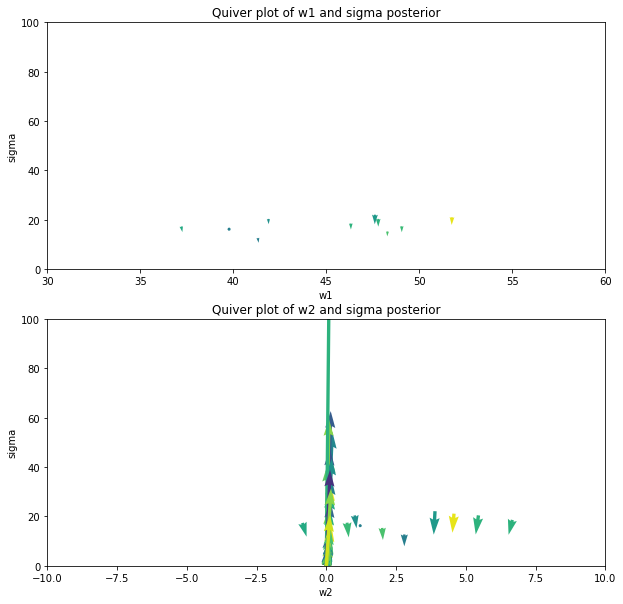

In [28]:
# Make a quiver plot with coordinates (w1_posterior_mean, sigma_square_posterior_mean) and end points (w1_posterior_mean_all, sigma_posterior). Color code with number of students in each school

# Convert to numpy arrays
w1_posterior_mean = onp.array(w1_posterior_mean)
sigma_posterior_mean = onp.array(sigma_posterior_mean)

# Get the number of students in each school
n_students = onp.array([len(df[df['sch_id'] == school_id]) for school_id in school_ids])

# Plot the quiver plot for w1
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
ax[0].quiver(w1_posterior_mean, sigma_posterior_mean, w1_posterior_mean_all - w1_posterior_mean, sigma_posterior_all - sigma_posterior_mean, n_students)
ax[0].set_xlim(30, 60)
ax[0].set_ylim(0, 100)
ax[0].set_xlabel("w1")
ax[0].set_ylabel("sigma")
ax[0].set_title("Quiver plot of w1 and sigma posterior")

# Plot the quiver plot for w2
ax[1].quiver(w2_posterior_mean, sigma_posterior_mean, w2_posterior_mean_all - w2_posterior_mean, sigma_posterior_all - sigma_posterior_mean, n_students)
ax[1].set_xlim(-10, 10)
ax[1].set_ylim(0, 100)
ax[1].set_xlabel("w2")
ax[1].set_ylabel("sigma")
ax[1].set_title("Quiver plot of w2 and sigma posterior")
plt.show()

**Interpretation of Result**